In [1]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ["TFHUB_CACHE_DIR"] = '/tmp/tfhub'

url = 'https://raw.githubusercontent.com/thestianchris/FakeReviewDetect/main/deceptive-opinion.csv'
df = pd.read_csv(url)
print(df.shape)
df.sample()

(1600, 5)


,deceptive,hotel,polarity,source,text
1474,deceptive,monaco,negative,MTurk,"While visiting the Chicago area, we chose the ..."


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14217231332869025747
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5717884928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5150606880270742717
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:08:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Standardise
for columns in df.columns:
    df['text'] = df['text'].str.lower()   #Covert the text to lower case
    df['text'].str.replace('[^\w\s]','') #Remove punctuation
    df['text'].str.strip() #Remove whitespace
    df['text'].str.replace("\n", " ") #Remove escape characters

#Shuffle the dataset to stop the model from picking up pattern of deceptive then truthful
df = shuffle(df)

#Get the max token from training data to be used in model
max_length = 0
for row in df['text']:
    if len(row.split(" ")) > max_length:
        max_length = len(row.split(" "))

print(max_length)

text_data = df['text'].values  #Get the data from the dataset to be used in model, we only are focused on the review and deceptive label
labels = df['deceptive'].values

#Split the data into test and train data with a 80/20 split, with 80% going to the train data
test_data, train_data, test_label, train_label = train_test_split(text_data,labels, test_size = 0.2, random_state = 0)

print(len(test_data))

784
320


C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_6172\2821475478.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'].str.replace('[^\w\s]','') #Remove punctuation


In [4]:
# Load Pretrained Word2Vec
import tensorflow_hub as hub
embed = hub.load('Embed')
embeddings = embed(["A long sentence.", "single-word", "http://example.com"])
print(embeddings.shape, embeddings.dtype)


(3, 500) <dtype: 'float32'>


In [2]:
def get_word2vec_enc(reviews):
    # Initialize an empty list to store the encoded reviews
    encoded_reviews = []
    
    # Iterate through the list of reviews
    for review in reviews:
        # Split the review into a list of individual words
        tokens = review.split(" ")
        # Get the word2vec embedding for the list of words
        word2vec_embedding = embed(tokens)
        # Append the embedding to the list of encoded reviews
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews

def get_padded_encoded_reviews(encoded_reviews):
    # Initialize to store the padded encoded reviews
    padded_reviews_encoding = []
    
    # Iterate through the list of encoded reviews
    for enc_review in encoded_reviews:
        # Calculate the number of zeros to pad the review with
        zero_padding_cnt = max_length - enc_review.shape[0]
        # Create an array of zeros with shape (1, 500) to use as padding
        pad = np.zeros((1, 500))
        # Iterate over the number of zeros to pad
        for i in range(zero_padding_cnt):
            # Concatenate the pad array and the encoded review along the 0th axis
            enc_review = np.concatenate((pad, enc_review), axis=0)
        # Append the padded review to the list of padded encoded reviews
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

def label_encode(label):
    # Encode the label as a one-hot encoding
    if label == 'truthful':
        return [1,0]
    else:
        return [0,1]

In [6]:
#Encode the reviews
'''
padded_encoded__train_reviews = get_padded_encoded_reviews(get_word2vec_enc(train_data))
padded_encoded__test_reviews = get_padded_encoded_reviews(get_word2vec_enc(test_data))
#Encode the labels
encoded_train_label = [label_encode(label) for label in train_label]
encoded_test_label = [label_encode(label) for label in test_label]
'''


'\npadded_encoded__train_reviews = get_padded_encoded_reviews(get_word2vec_enc(train_data))\npadded_encoded__test_reviews = get_padded_encoded_reviews(get_word2vec_enc(test_data))\n#Encode the labels\nencoded_train_label = [label_encode(label) for label in train_label]\nencoded_test_label = [label_encode(label) for label in test_label]\n'

In [2]:
#Turn values into numpy arrays so can be used in model
'''
train_data = np.array(padded_encoded__train_reviews)
train_label = np.array(encoded_train_label)

test_data = np.array(padded_encoded__test_reviews)
test_label = np.array(encoded_test_label)

#Save locally
np.save('train_data', train_data)
np.save('train_label', train_label)
np.save('test_data', test_data)
np.save('test_label', test_label)

'''
#Load locally
train_data = np.load('train_data.npy')
train_label= np.load('train_label.npy')

test_data = np.load('test_data.npy')
test_label = np.load('test_label.npy')

print(len(test_data))
print(len(test_label))

print(train_data.shape)
print(test_label.shape)

320
320
(1280, 784, 500)
(320, 2)


First Version:
Basic LSTM NO ADD ON  


RUN 1: 30 EPOCH BATCH 100, VALIDATION 0.2 Test score: 0.6269838809967041, Test accuracy: 0.6468750238418579

RUN 2: 50 EPOCH BATCH 100, VALIDATION 0.2 Test score: 0.5954033732414246, Test accuracy: 0.715624988079071

RUN 3: 50 EPOCH BATCH 150, VALIDATION 0.2 Test score: 0.5615556240081787, Test accuracy: 0.731249988079071

RUN 4: 75 EPOCH BATCH 150, VALIDATION 0.2 Test score: 0.5727009773254395, Test accuracy: 0.734375

RUN 5: 100 EPOCH BATCH 150, VALIDATION 0.2 Test score: 0.5153071284294128, Test accuracy: 0.748124988079071

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Bidirectional

In [4]:
# Define the model's architecture
def build_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(128))
  model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
  return model

model1 = build_model()
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model1.fit(
    train_data, 
    train_label, 
    epochs = 100,
    batch_size = 150,
    validation_split=0.2,
) 

model1.summary() 
score, acc = model1.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)



Epoch 1/100
7/7 [==============================] - 4s 250ms/step - loss: 0.6905 - accuracy: 0.5566 - val_loss: 0.6890 - val_accuracy: 0.5625
Epoch 2/100
7/7 [==============================] - 1s 146ms/step - loss: 0.6797 - accuracy: 0.6035 - val_loss: 0.6720 - val_accuracy: 0.5859
Epoch 3/100
7/7 [==============================] - 1s 147ms/step - loss: 0.6503 - accuracy: 0.6367 - val_loss: 0.6787 - val_accuracy: 0.5781
Epoch 4/100
7/7 [==============================] - 1s 162ms/step - loss: 0.6490 - accuracy: 0.6436 - val_loss: 0.6629 - val_accuracy: 0.5938
Epoch 5/100
7/7 [==============================] - 1s 154ms/step - loss: 0.6593 - accuracy: 0.6182 - val_loss: 0.6635 - val_accuracy: 0.5859
Epoch 6/100
7/7 [==============================] - 1s 150ms/step - loss: 0.6515 - accuracy: 0.6377 - val_loss: 0.6686 - val_accuracy: 0.5938
Epoch 7/100
7/7 [==============================] - 1s 154ms/step - loss: 0.6426 - accuracy: 0.6475 - val_loss: 0.6532 - val_accuracy: 0.5898
Epoch 8/100
7

2ND VERSION:

128 UNIT LSTM + DROPOUT + DENSE VARYING UNIT WITH REGULARIZERS + epochs = 100,batch_size = 150,validation_split=0.2,

RUN 1; DROPOUT: 0.5, 32 DENSE, REGULARIZER: 0.001, Test score: 0.7574900984764099, Test accuracy: 0.7124999761581421

RUN 2; DROPOUT: 0.3, 32 DENSE, REGULARIZER: 0.001, Test score: 0.8907718658447266, Test accuracy: 0.734375

RUN 3; DROPOUT: 0.2, 32 DENSE, REGULARIZER: 0.001, Test score: 0.9743309020996094, Test accuracy: 0.637499988079071

RUN 4; DROPOUT: 0.3, 64 DENSE, REGULARIZER: 0.001, Test score: 1.236046552658081,  Test accuracy: 0.668749988079071

RUN 5; DROPOUT: 0.3, 64 DENSE, REGULARIZER: 0.01,  Test score: 0.5993211269378662, Test accuracy: 0.765625

RUN 6; DROPOUT: 0.3, 64 DENSE, REGULARIZER: 0.005, Test score: 0.6985389590263367, Test accuracy: 0.5531250238418579 

RUN 7; DROPOUT: 0.3, 64 DENSE, REGULARIZER: 0.0085, Test score: 0.6136771440505981, Test accuracy: 0.734375

In [6]:
# Define the model's architecture
def build_model(regularization_lambda):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(128))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=regularizers.l2(regularization_lambda),
                                  bias_regularizer=regularizers.l2(regularization_lambda)))
  model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
  return model

model2 = build_model(0.0085)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model2.fit(
    train_data, 
    train_label, 
    epochs = 100,
    batch_size = 150,
    validation_split=0.2,
) 

model2.summary() 
score, acc = model2.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)


Epoch 1/100
7/7 [==============================] - 4s 255ms/step - loss: 1.3763 - accuracy: 0.5059 - val_loss: 1.3291 - val_accuracy: 0.5234
Epoch 2/100
7/7 [==============================] - 1s 139ms/step - loss: 1.2935 - accuracy: 0.5596 - val_loss: 1.2508 - val_accuracy: 0.5703
Epoch 3/100
7/7 [==============================] - 1s 144ms/step - loss: 1.2137 - accuracy: 0.5986 - val_loss: 1.1865 - val_accuracy: 0.5156
Epoch 4/100
7/7 [==============================] - 1s 149ms/step - loss: 1.1418 - accuracy: 0.5938 - val_loss: 1.1110 - val_accuracy: 0.6094
Epoch 5/100
7/7 [==============================] - 1s 142ms/step - loss: 1.0729 - accuracy: 0.6113 - val_loss: 1.0659 - val_accuracy: 0.5586
Epoch 6/100
7/7 [==============================] - 1s 143ms/step - loss: 1.0259 - accuracy: 0.6182 - val_loss: 0.9956 - val_accuracy: 0.6172
Epoch 7/100
7/7 [==============================] - 1s 141ms/step - loss: 0.9700 - accuracy: 0.6348 - val_loss: 0.9466 - val_accuracy: 0.6211
Epoch 8/100
7

3rd VERSION:

128 UNIT LSTM + 2 x DROPOUT + 2 x DENSE VARYING UNIT WITH REGULARIZERS + epochs = 100,batch_size = 150,validation_split=0.2,

RUN 1; DROPOUT: 0.3/0.3, 64/32 DENSE, REGULARIZER: 0.0085, Test score: 0.6737568378448486, Test accuracy: 0.6312500238418579.

RUN 2; DROPOUT: 0.3/0.3, 64/32 DENSE, REGULARIZER: 0.01,   Test score: 0.7792227864265442, Test accuracy: 0.6875.

RUN 3; DROPOUT: 0.3/0.2, 64/32 DENSE, REGULARIZER: 0.01,   Test score: 0.6192814111709595, Test accuracy: 0.7249999761581421.

RUN 4; DROPOUT: 0.3/0.2, 64/32 DENSE, REGULARIZER: 0.0125, Test score: 0.6487112641334534, Test accuracy: 0.653124988079071.

RUN 5; DROPOUT: 0.2/0.2, 128/64 DENSE, REGULARIZER: 0.01,  Test score: 1.031381368637085,  Test accuracy: 0.6656249761581421.

RUN 6; DROPOUT: 0.2/0.2, 64/64 DENSE, REGULARIZER: 0.01,   Test score: 0.8899283409118652, Test accuracy: 0.659375011920929.

In [5]:
# Define the model's architecture
def build_model(regularization_lambda):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(128))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=regularizers.l2(regularization_lambda),
                                  bias_regularizer=regularizers.l2(regularization_lambda)))
  model.add(tf.keras.layers.Dropout(0.2))                                
  model.add(tf.keras.layers.Dense(32, activation='relu',
                                  kernel_regularizer=regularizers.l2(regularization_lambda),
                                  bias_regularizer=regularizers.l2(regularization_lambda)))                                
  model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
  return model

model3 = build_model(0.01)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model3.fit(
    train_data, 
    train_label, 
    epochs = 100,
    batch_size = 150,
    validation_split=0.2,
) 

model3.summary() 
score, acc = model3.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/100
7/7 [==============================] - 4s 248ms/step - loss: 1.9370 - accuracy: 0.4971 - val_loss: 1.8612 - val_accuracy: 0.4531
Epoch 2/100
7/7 [==============================] - 1s 136ms/step - loss: 1.8067 - accuracy: 0.5400 - val_loss: 1.7376 - val_accuracy: 0.5352
Epoch 3/100
7/7 [==============================] - 1s 142ms/step - loss: 1.6862 - accuracy: 0.5635 - val_loss: 1.6219 - val_accuracy: 0.5938
Epoch 4/100
7/7 [==============================] - 1s 146ms/step - loss: 1.5756 - accuracy: 0.5771 - val_loss: 1.5157 - val_accuracy: 0.5938
Epoch 5/100
7/7 [==============================] - 1s 136ms/step - loss: 1.4729 - accuracy: 0.6035 - val_loss: 1.4355 - val_accuracy: 0.5234
Epoch 6/100
7/7 [==============================] - 1s 139ms/step - loss: 1.3928 - accuracy: 0.5635 - val_loss: 1.3420 - val_accuracy: 0.5977
Epoch 7/100
7/7 [==============================] - 1s 147ms/step - loss: 1.3096 - accuracy: 0.6035 - val_loss: 1.2789 - val_accuracy: 0.5664
Epoch 8/100
7

Running model for longer epochs, then retrain up to best epoch
using different levels of regularization ontop of more dense layers. 

This approach is under the idea that providing more power will allow for higher accuracy with retraining compared to the previous runs

run 1: reducing, 100 lstm unit, 32/16 dense, 0.0085 reg on only the first 32 unit dense, dropout 0.5x2, Test score: 1.3817576169967651 Test accuracy: 0.7250000238418579

run 2: 100, 64/32, dropout 0.3/0.2, reg 0.01 on all dense, Test score: 0.6792866587638855 Test accuracy: 0.7437499761581421

run 3: 100, 32/16, dropout 0.2/0.3, reg 0.001, flatten after lstm, Test score: 1.59714674949646 Test accuracy: 0.706250011920929

run 4: 100, 32/16, dropout 0.3/0.2, reg 0.01, flatten after lstm, Test score: 1.155207633972168 Test accuracy: 0.746874988079071

run 5: 100, 64/32, dropout 0.3/0.2, reg 0.0085, flatten after lstm: Test score: 1.101473331451416 Test accuracy: 0.7437499761581421

run 6: 100, 64/32, dropout 0.3/0.2, reg 0.01, flatten after lstm: Test score: 1.0823814868927002 Test accuracy: 0.7281249761581421

RUN 7: 100, 32/16, DROPOUT 0.3/0.2, reg 0.0085, flatten after lstm: Test score: 1.0928924083709717 Test accuracy: 0.753125011920929


In [4]:
# Define the model's architecture
def build_model(regularization_lambda):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(100)),
  model.add(tf.keras.layers.Flatten()),
  model.add(tf.keras.layers.Dropout(0.3)), 
  model.add(tf.keras.layers.Dense(32, activation='relu',
                                  kernel_regularizer=regularizers.l2(regularization_lambda),
                                  bias_regularizer=regularizers.l2(regularization_lambda))),
  model.add(tf.keras.layers.Dropout(0.2)),    
  model.add(tf.keras.layers.Dense(16, activation='relu',
                                  kernel_regularizer=regularizers.l2(regularization_lambda),
                                  bias_regularizer=regularizers.l2(regularization_lambda))),                                                                                   
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model


# Compile the model
model4 = build_model(0.0085)
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model4.fit(
    train_data, 
    train_label, 
    epochs = 200,
    batch_size = 150,
    validation_split=0.2,
) 

model4.summary()   


Epoch 1/200
7/7 [==============================] - 8s 293ms/step - loss: 1.2506 - accuracy: 0.5010 - val_loss: 1.2209 - val_accuracy: 0.5664
Epoch 2/200
7/7 [==============================] - 1s 152ms/step - loss: 1.2011 - accuracy: 0.5693 - val_loss: 1.1725 - val_accuracy: 0.5820
Epoch 3/200
7/7 [==============================] - 1s 170ms/step - loss: 1.1546 - accuracy: 0.5576 - val_loss: 1.1274 - val_accuracy: 0.5977
Epoch 4/200
7/7 [==============================] - 1s 167ms/step - loss: 1.1100 - accuracy: 0.5928 - val_loss: 1.0807 - val_accuracy: 0.6289
Epoch 5/200
7/7 [==============================] - 1s 152ms/step - loss: 1.0649 - accuracy: 0.6006 - val_loss: 1.0350 - val_accuracy: 0.6133
Epoch 6/200
7/7 [==============================] - 1s 147ms/step - loss: 1.0225 - accuracy: 0.6035 - val_loss: 0.9976 - val_accuracy: 0.6445
Epoch 7/200
7/7 [==============================] - 1s 145ms/step - loss: 0.9899 - accuracy: 0.6338 - val_loss: 0.9730 - val_accuracy: 0.6289
Epoch 8/200
7

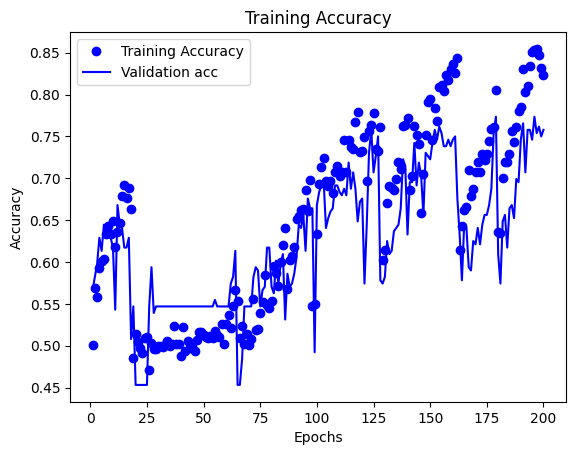

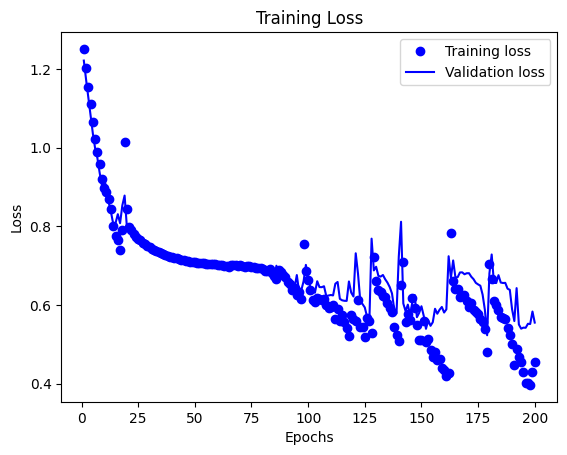

178


In [5]:
history_dict = history.history
history_dict.keys() # the data gathered during training
import matplotlib.pyplot as plt

#plot of the accuracy
def plot_acc():
    plt.clf()
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(acc) + 1)
    solid_blue_line = 'b'
    blue_dots = 'bo'

    plt.plot(epochs, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#plot of the loss
def plot_loss():
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(loss) + 1)
    solid_blue_line = 'b'
    blue_dots = 'bo'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_acc()
plot_loss()
early_stopping_epoch = np.argmax(history.history["val_accuracy"])
print(early_stopping_epoch)

In [12]:
tf.keras.backend.clear_session()
'''
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()
'''

"\nnew_model = tf.keras.models.load_model('saved_model/my_model')\nnew_model.summary()\n"

In [6]:
history = model4.fit(
    train_data,                     
    train_label,
    epochs=early_stopping_epoch, #Stop where overfitting start
    batch_size = 150, 
    validation_split=0.2,
)

Epoch 1/178
7/7 [==============================] - 2s 230ms/step - loss: 0.3984 - accuracy: 0.8516 - val_loss: 0.5289 - val_accuracy: 0.7656
Epoch 2/178
7/7 [==============================] - 1s 140ms/step - loss: 0.4042 - accuracy: 0.8350 - val_loss: 0.5818 - val_accuracy: 0.7656
Epoch 3/178
7/7 [==============================] - 1s 146ms/step - loss: 0.4173 - accuracy: 0.8379 - val_loss: 0.5792 - val_accuracy: 0.7422
Epoch 4/178
7/7 [==============================] - 1s 146ms/step - loss: 0.4201 - accuracy: 0.8281 - val_loss: 0.7217 - val_accuracy: 0.7031
Epoch 5/178
7/7 [==============================] - 1s 148ms/step - loss: 0.4582 - accuracy: 0.8389 - val_loss: 0.5416 - val_accuracy: 0.7656
Epoch 6/178
7/7 [==============================] - 1s 148ms/step - loss: 0.3986 - accuracy: 0.8506 - val_loss: 0.6247 - val_accuracy: 0.7227
Epoch 7/178
7/7 [==============================] - 1s 147ms/step - loss: 0.4442 - accuracy: 0.8252 - val_loss: 0.6085 - val_accuracy: 0.7148
Epoch 8/178
7

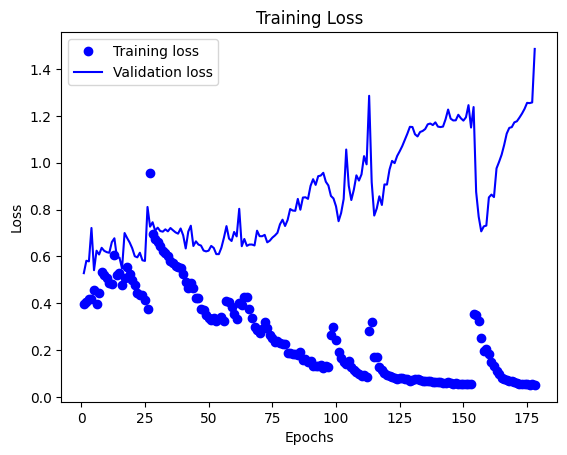

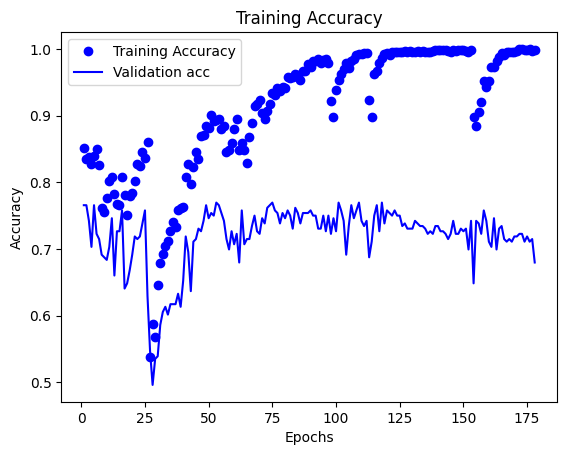

In [7]:
history_dict = history.history #Get the data stored from training
plot_loss()
plot_acc()

In [8]:
score, acc = model4.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

10/10 - 0s - loss: 1.0929 - accuracy: 0.7531 - 310ms/epoch - 31ms/step
Test score: 1.0928924083709717
Test accuracy: 0.753125011920929


In [ ]:
model4.save('saved_model/my_model')